In [42]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%run 0_parameters.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      
Using filename= ../data/2019-04-25
{'w': 28, 'minibatch_size': 100, 'train_batch_size': 50000, 'test_batch_size': 10000, 'noise_batch_size': 1000, 'mean': 0.1307, 'std': 0.3081, 'N_pic': 128, 'offset_std': 30, 'offset_max': 34, 'noise': 0.75, 'contrast': 0.7, 'sf_0': 0.1, 'B_sf': 0.1, 'N_theta': 6, 'N_azimuth': 24, 'N_eccentricity': 10, 'N_phase': 2, 'rho': 1.41, 'bias_deconv': True, 'p_dropout': 0.0, 'dim1': 1000, 'dim2': 1000, 'lr': 0.005, 'do_adam': True, 'bn1_bn_momentum': 0.5, 'bn2_bn_momentum': 0.5, 'momentum': 0.3, 'epochs': 60, 'num_processes': 1, 'no_cuda': True, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-04-25', 'seed': 2019, 'N_cv': 10, 'do_compute': True}
Overwriting train.py
2019-04-25T15:08:36+02:00

CPython 3.7.3
I

In [43]:
%load_ext version_information
%version_information numpy, matplotlib, bayesianchangepoint

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.7.3 64bit [Clang 10.0.1 (clang-1001.0.46.3)]
IPython 7.5.0
OS Darwin 18.5.0 x86_64 i386 64bit
numpy 1.16.3
matplotlib 3.0.3
bayesianchangepoint 0.1
Tue May 14 15:34:33 2019 CEST

In [44]:
import os
if not os.path.exists('figures/BCP'):
    os.makedirs('figures/BCP')


# the switching binomial generative model


In [45]:
t_titre = 35
t_label = 25
fig_width= 15
N_scan = 100
#N_scan = 10 # DEBUG

In [46]:
msfigpath = '../PasturelMontagniniPerrinet2019/figures'
observer = 'AM'
mode = 'pari'
exts = ['.png', '.svg', '.pdf']
dpi = 400
from aSPEM import Analysis
e = Analysis(observer=observer, mode=mode)

/!\ Le fichier Delete n'existe pas pour fct_velocity_2_step_False_whitening !


# the online BCP model: figures for the model

In [47]:
N_trials = 100
seed = 2020
np.random.seed(seed)

trials = np.arange(N_trials)
p = np.random.rand(N_trials, 1, 3)
p[:, :, 2] = 0
p[N_trials//2, 0, 2] = 1

p[:N_trials//2, :, 1] = .15
p[N_trials//2:, :, 1] = .85

for trial in trials:
    p[trial, :, 0] =  p[trial, :, 1] > np.random.rand() # Bernouilli trial

In [48]:
N_trials_show = 10
print(p[:N_trials_show, 0, :])

[[0.   0.15 0.  ]
 [0.   0.15 0.  ]
 [0.   0.15 0.  ]
 [0.   0.15 0.  ]
 [0.   0.15 0.  ]
 [0.   0.15 0.  ]
 [1.   0.15 0.  ]
 [1.   0.15 0.  ]
 [1.   0.15 0.  ]
 [0.   0.15 0.  ]]


In [49]:
import bayesianchangepoint as bcp
tau = N_trials/5.
h = 1/tau
i_block = 0

p0, r0 =  0.5, 1.0
p_bar, r_bar, beliefs = bcp.inference(p[:, i_block, 0], h=h, p0=p0, r0=r0)
p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode='max', p0=p0)

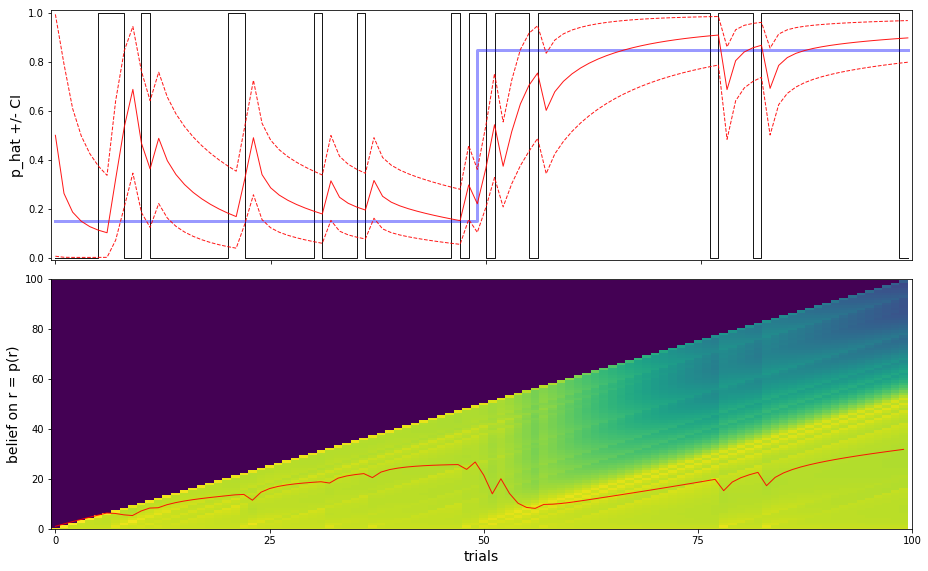

In [50]:
fig, axs = bcp.plot_inference(p[:, i_block, 0], p[:, i_block, 1], p_bar, r_bar, beliefs, eps=1e-18, p0=p0, max_run_length=100)
plt.show()

In [51]:
N_trials = 10
seed = 2020
np.random.seed(seed)

trials = np.arange(N_trials)
p = np.random.rand(N_trials, 3)
p[:, 2] = 0
p[N_trials//2, 2] = 1

p[:N_trials//2, 1] = .1
p[N_trials//2:, 1] = .9

for trial in trials:
    p[trial, 0] =  p[trial, 1] > np.random.rand() # Bernouilli trial


    
tau = N_trials//2
h = 1/tau
p_bar, r_bar, beliefs = bcp.inference(p[:, 0], h=h, p0=p0, r0=r0)
p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode='max', p0=p0)

In [52]:
r_hat

array([1., 2., 3., 4., 5., 6., 2., 3., 4., 5.])

In [53]:
r_true = r_hat.copy()
r_true[5] = 1

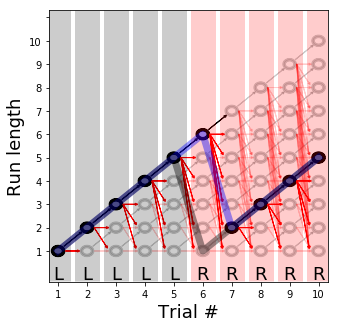

In [54]:
from matplotlib.patches import Circle, Wedge
from matplotlib.collections import PatchCollection

def arrow_1(ax, x, y, alpha):
    plt.arrow(x+r_cir, y+r_cir, 1-(r_cir*2)-(s_arrow/2), 1-(r_cir*2)-(s_arrow/2),
              head_width=s_arrow, head_length=s_arrow, fc=c_f1, ec=c_f1, alpha=alpha)


def arrow_2(ax, x, y, alpha):
    for r in range(0, y+1) :
        if r==0 : a=0
        else :    a=r_cir

        plt.arrow(x+r_cir+(s_arrow/2), y, 1-(r_cir*2)-(s_arrow*2), -r+a,
                  head_width=s_arrow, head_length=s_arrow, fc=c_f2, ec=c_f2, alpha=alpha)


fig_width = 5
r_cir, lw_cir, s_arrow = 0.2, 3, 0.09
alpha = .2

c_f1, c_f2, c_cir = 'k', 'r', 'k'
labelsize = 18
num = N_trials

Cir, Cir_a = [], []
#trials = range(int(num*1.6180)+1)

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width), sharex=True)
#fig.set_figwidth = 3
#fig.set_figheight = 3

for x in trials:
    if x < num: runlengths = range(x+1)
    else:       runlengths = range(num)
    max_r = num-1
    
    for r in runlengths:
        if r==r_hat[x]-1 : Cir += [Wedge((x, r), r_cir, 0, 360, width=r_cir/10)]
        else :             Cir_a += [Wedge((x, r), r_cir, 0, 360, width=r_cir/10)]

        if x < N_trials-1 :
            if r==r_hat[x]-1 : a=1
            else :             a=alpha
            arrow_1(ax, x, r, alpha=a)
            arrow_2(ax, x, r, alpha=a)

    ax.vlines(x, -1.3, (num+0.3), color=(p[x, 0], 0, 0), lw=25, alpha=0.2)
    if p[x, 0]==0 : t='L'
    else :          t='R'
    ax.text(x, -1, t, ha='center', va='center', fontsize=labelsize)
    
ax.add_collection(PatchCollection(Cir, color=c_cir, lw=lw_cir))
ax.add_collection(PatchCollection(Cir_a, color=c_cir, alpha=alpha, lw=lw_cir))

ax.plot(r_hat-1, lw=7, alpha=0.4, c='b')
ax.plot(r_true-1, lw=7, alpha=0.4, c='k')

ax.tick_params(bottom=True, top=False, right=False, left=True)
ax.set_ylabel('Run length', fontsize=labelsize)
ax.set_xlabel('Trial #', fontsize=labelsize)
ax.set_xticks(trials)
ax.set_yticks(np.arange(0, N_trials+1))
ax.set_xticklabels(np.arange(1, N_trials+1))
ax.set_yticklabels(np.arange(1, N_trials+1))


ax.axis([-0.32, (num+0.32)-1, -1.32, (num+0.32)])
#for ext in exts: plt.savefig('figures/BCP/bcp_model_layer_%s%s' % (layer, ext))


plt.show()

In [55]:
figname = '3_BCP_model'
for ext in exts: fig.savefig('{msfigpath}/{figname}'.format(msfigpath=msfigpath, figname=figname) + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)

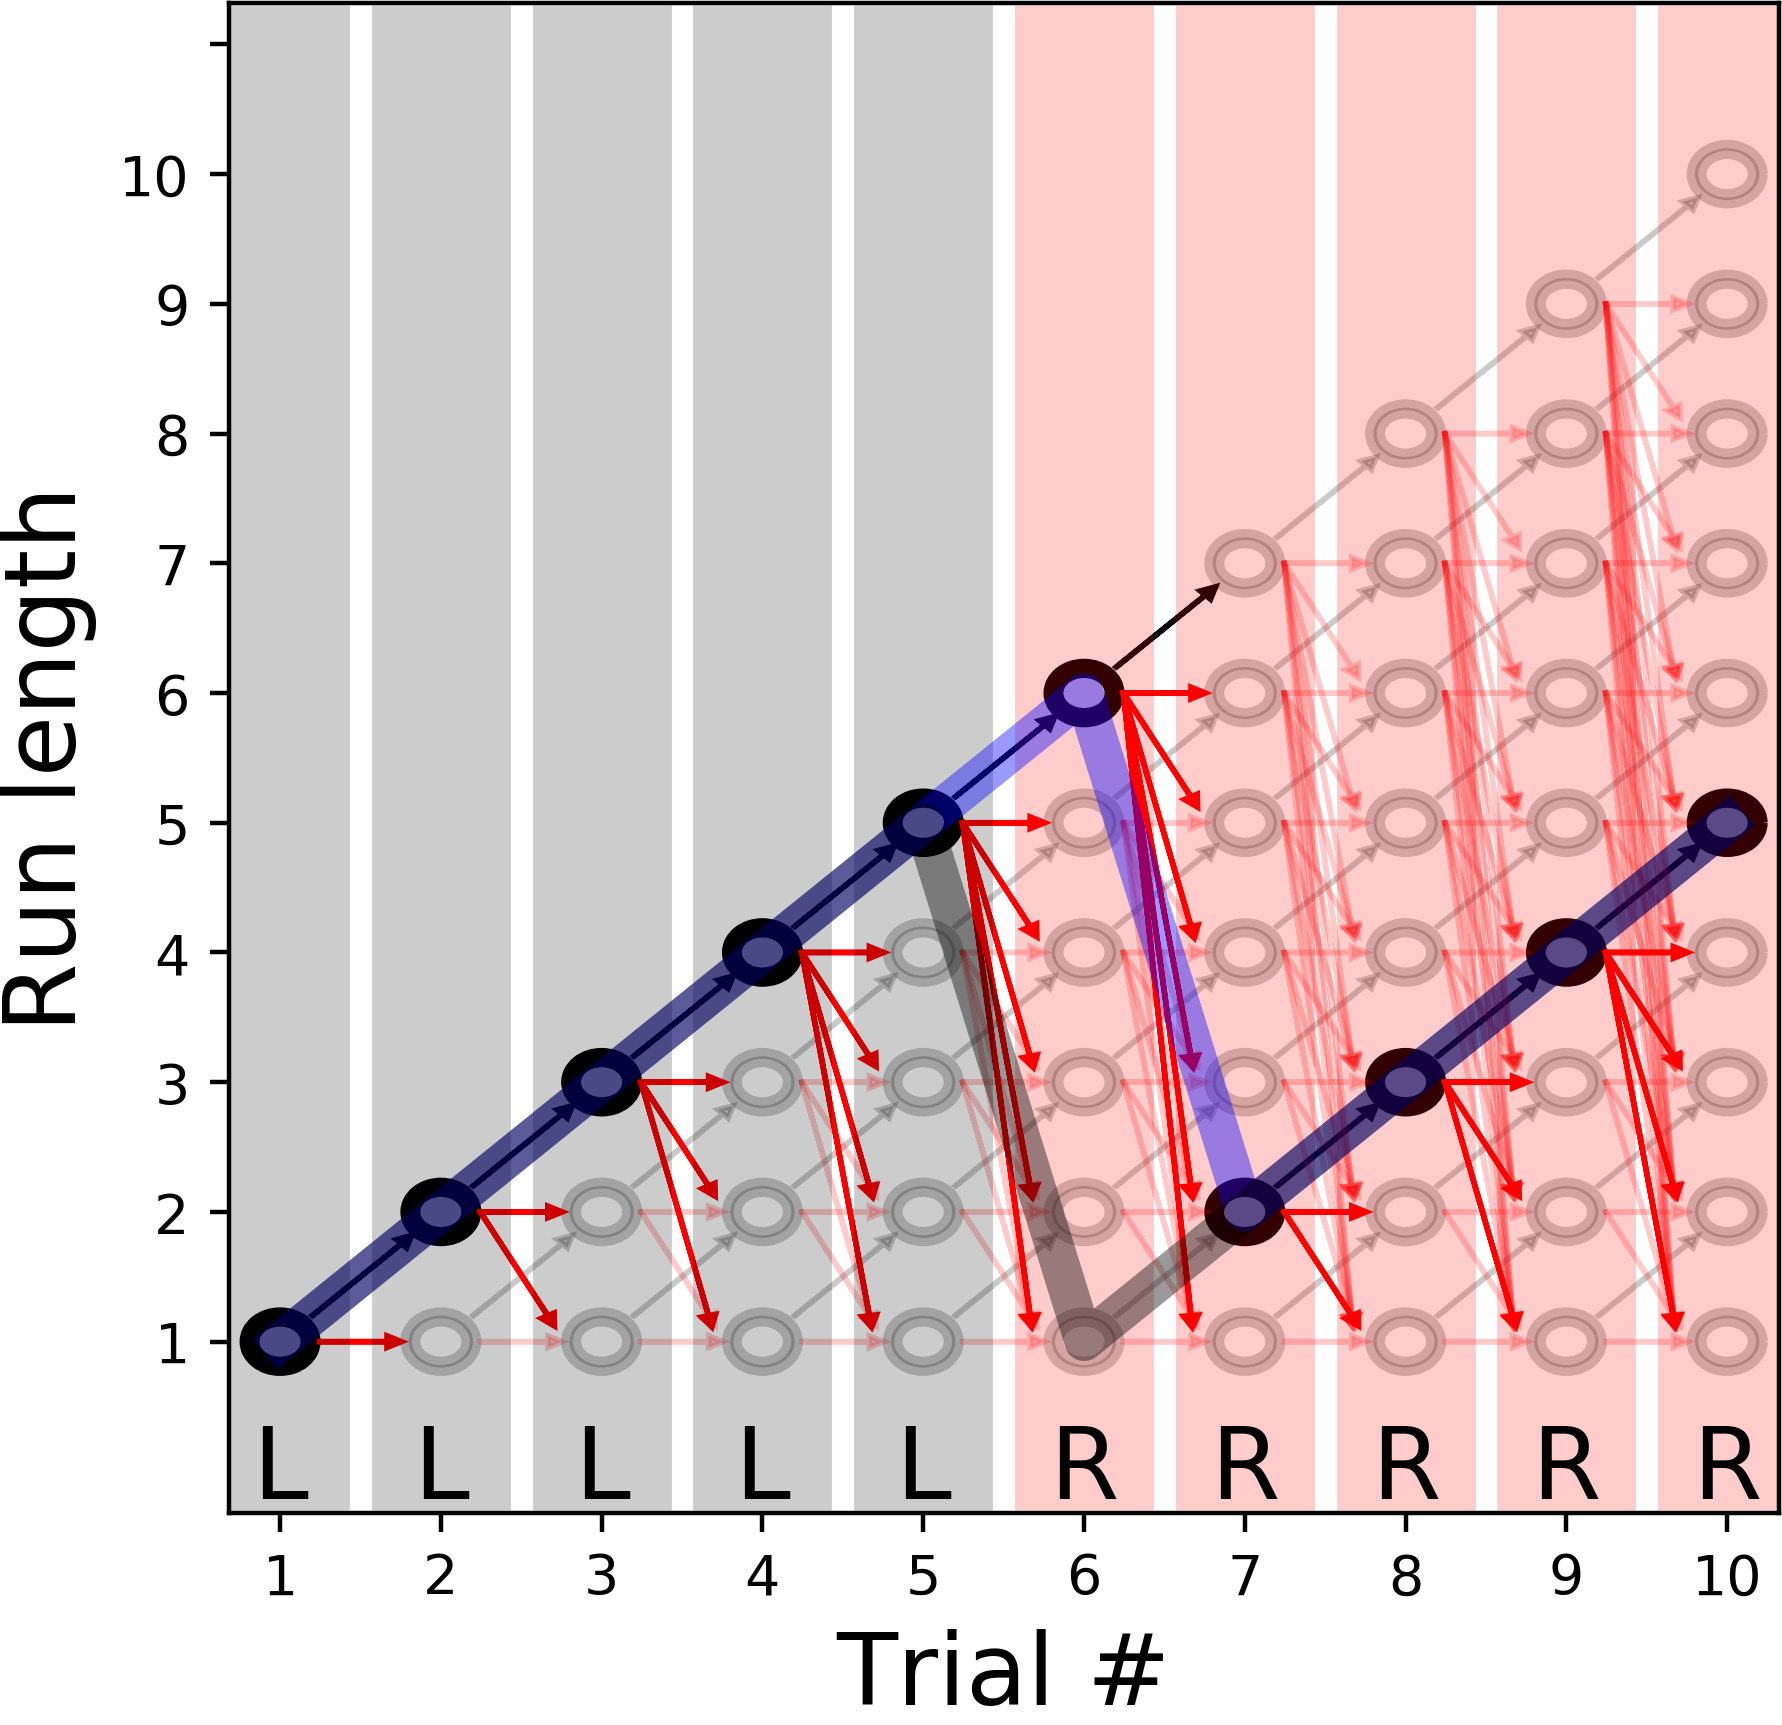

In [56]:
from IPython.display import Image
Image('{msfigpath}/{figname}.png'.format(msfigpath=msfigpath, figname=figname))

# chosen readout with a comparison with 'fixed'

In [60]:
figname = '3_BCP_readouts'

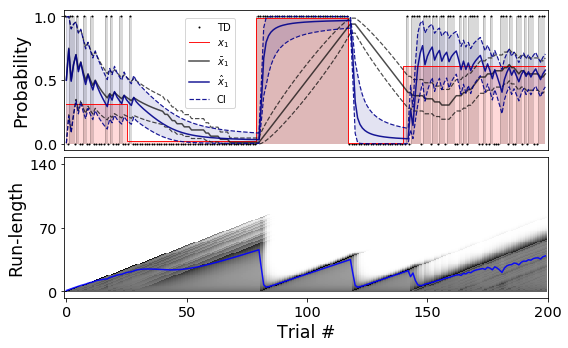

In [69]:
fig, ax1, ax2 = e.plot_bcp(mode=['mean'], mode_compare='fixed', block=1, trial=50, max_run_length=85, 
                 fig_width=8, t_label=26, show_title=None, show_trial=False, N_scan=0)
for card in ['bottom', 'top']: 
    ax1.spines[card].set_visible(False)
    ax2.spines[card].set_visible(False)
#ax1.legend(loc='best')
ax2.set_ylim(0, 80)
     
for ext in exts: fig.savefig('{msfigpath}/{figname}'.format(msfigpath=msfigpath, figname=figname) + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)

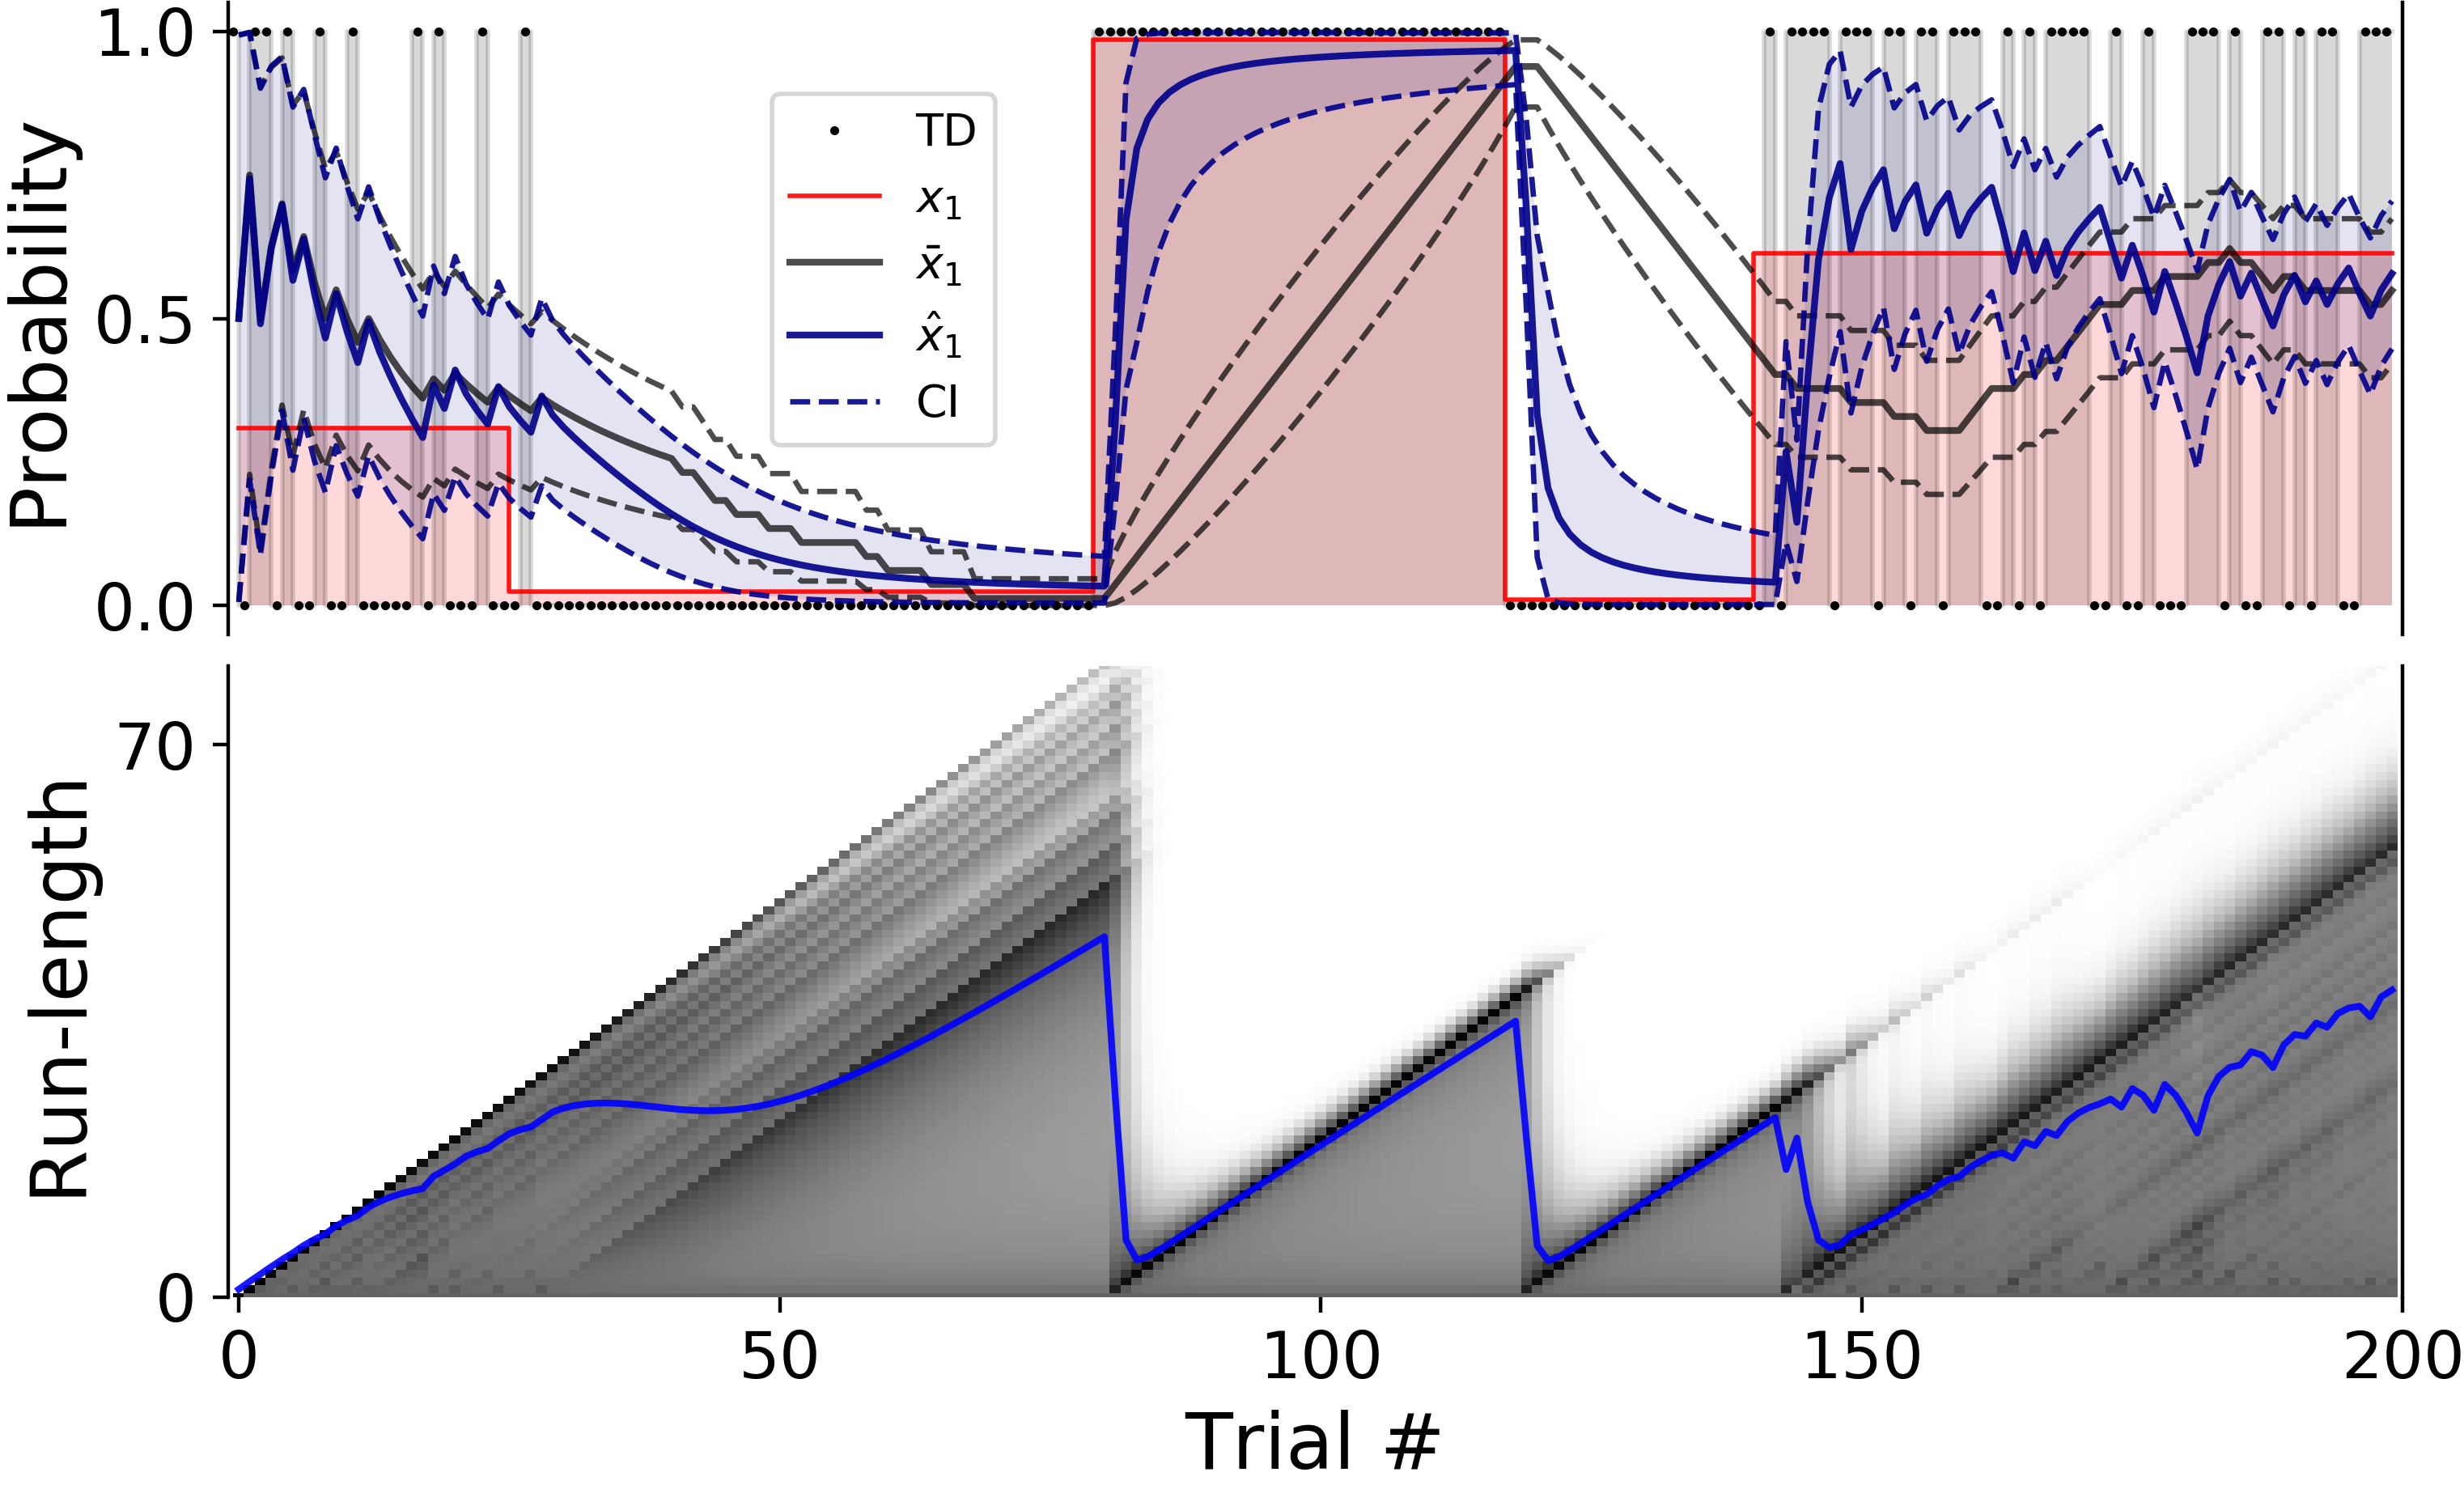

In [70]:
from IPython.display import Image
Image('{msfigpath}/{figname}.png'.format(msfigpath=msfigpath, figname=figname))

# evaluating the best hazard rate using a likelihood score

Vérifier tau !

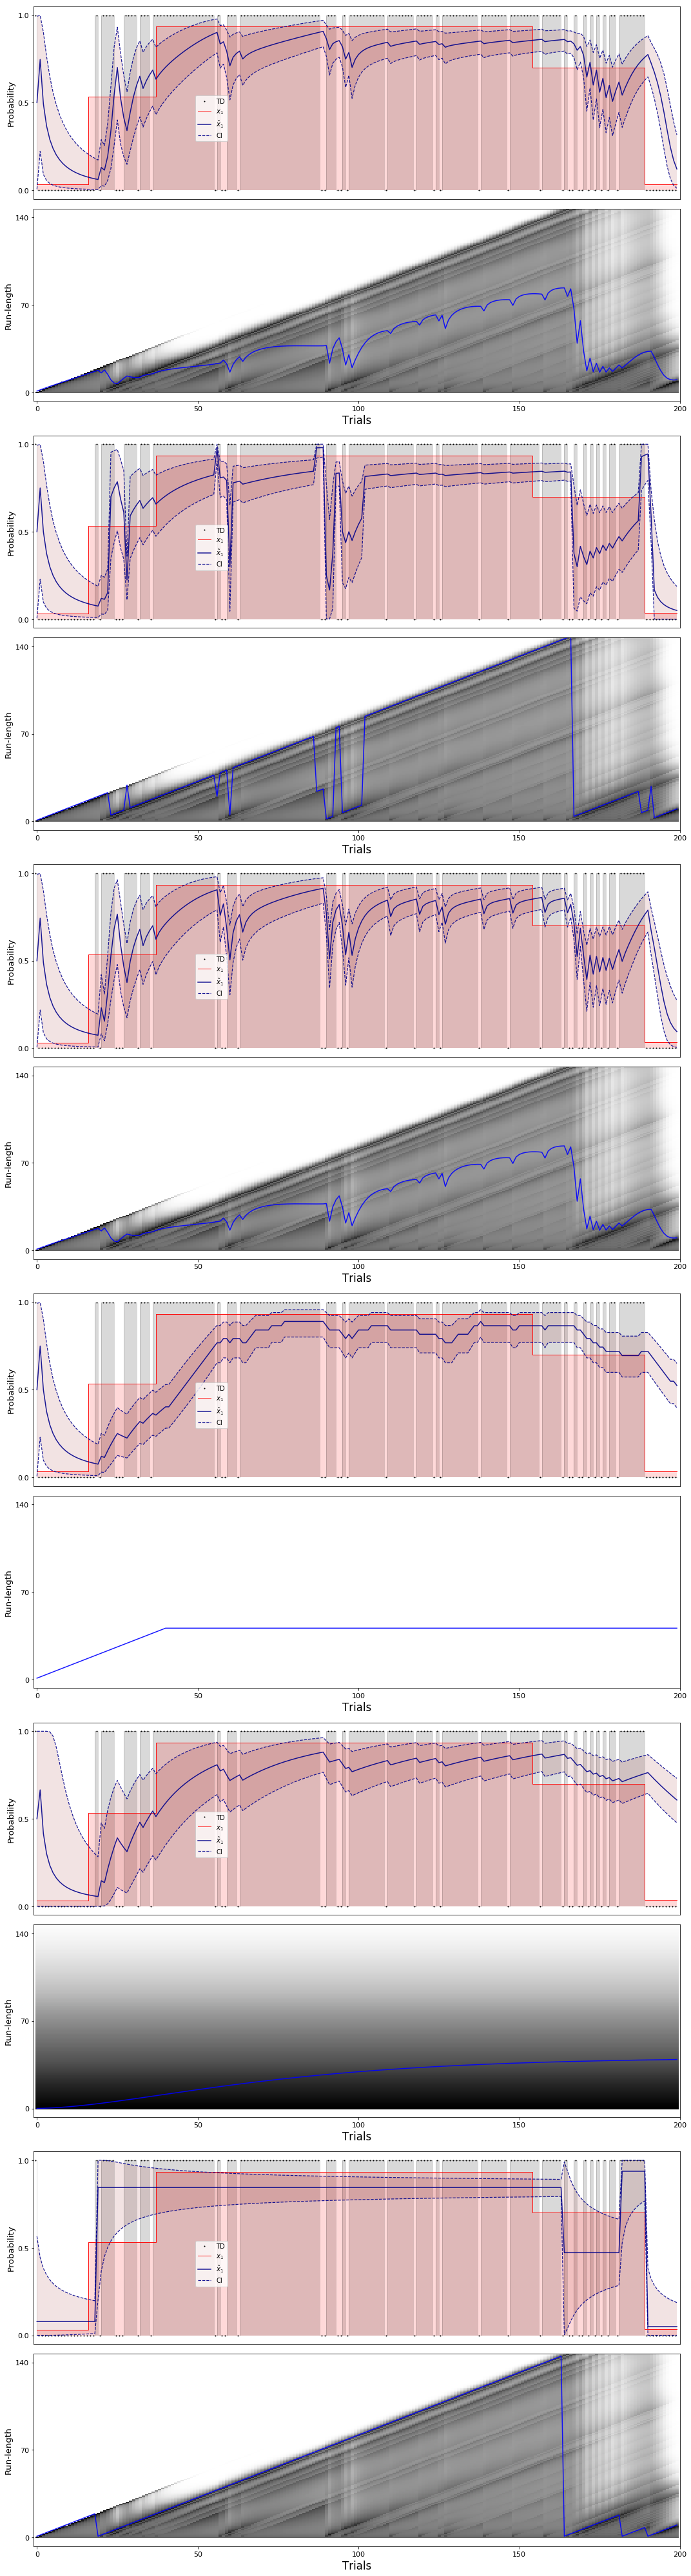

In [19]:
fig, ax1, ax2  = e.plot_bcp(show_trial=False, N_scan=0, block=2, trial=50)
for ext in exts:
    fig.savefig('figures/BCP/BCP_readouts' + ext, dpi=dpi)

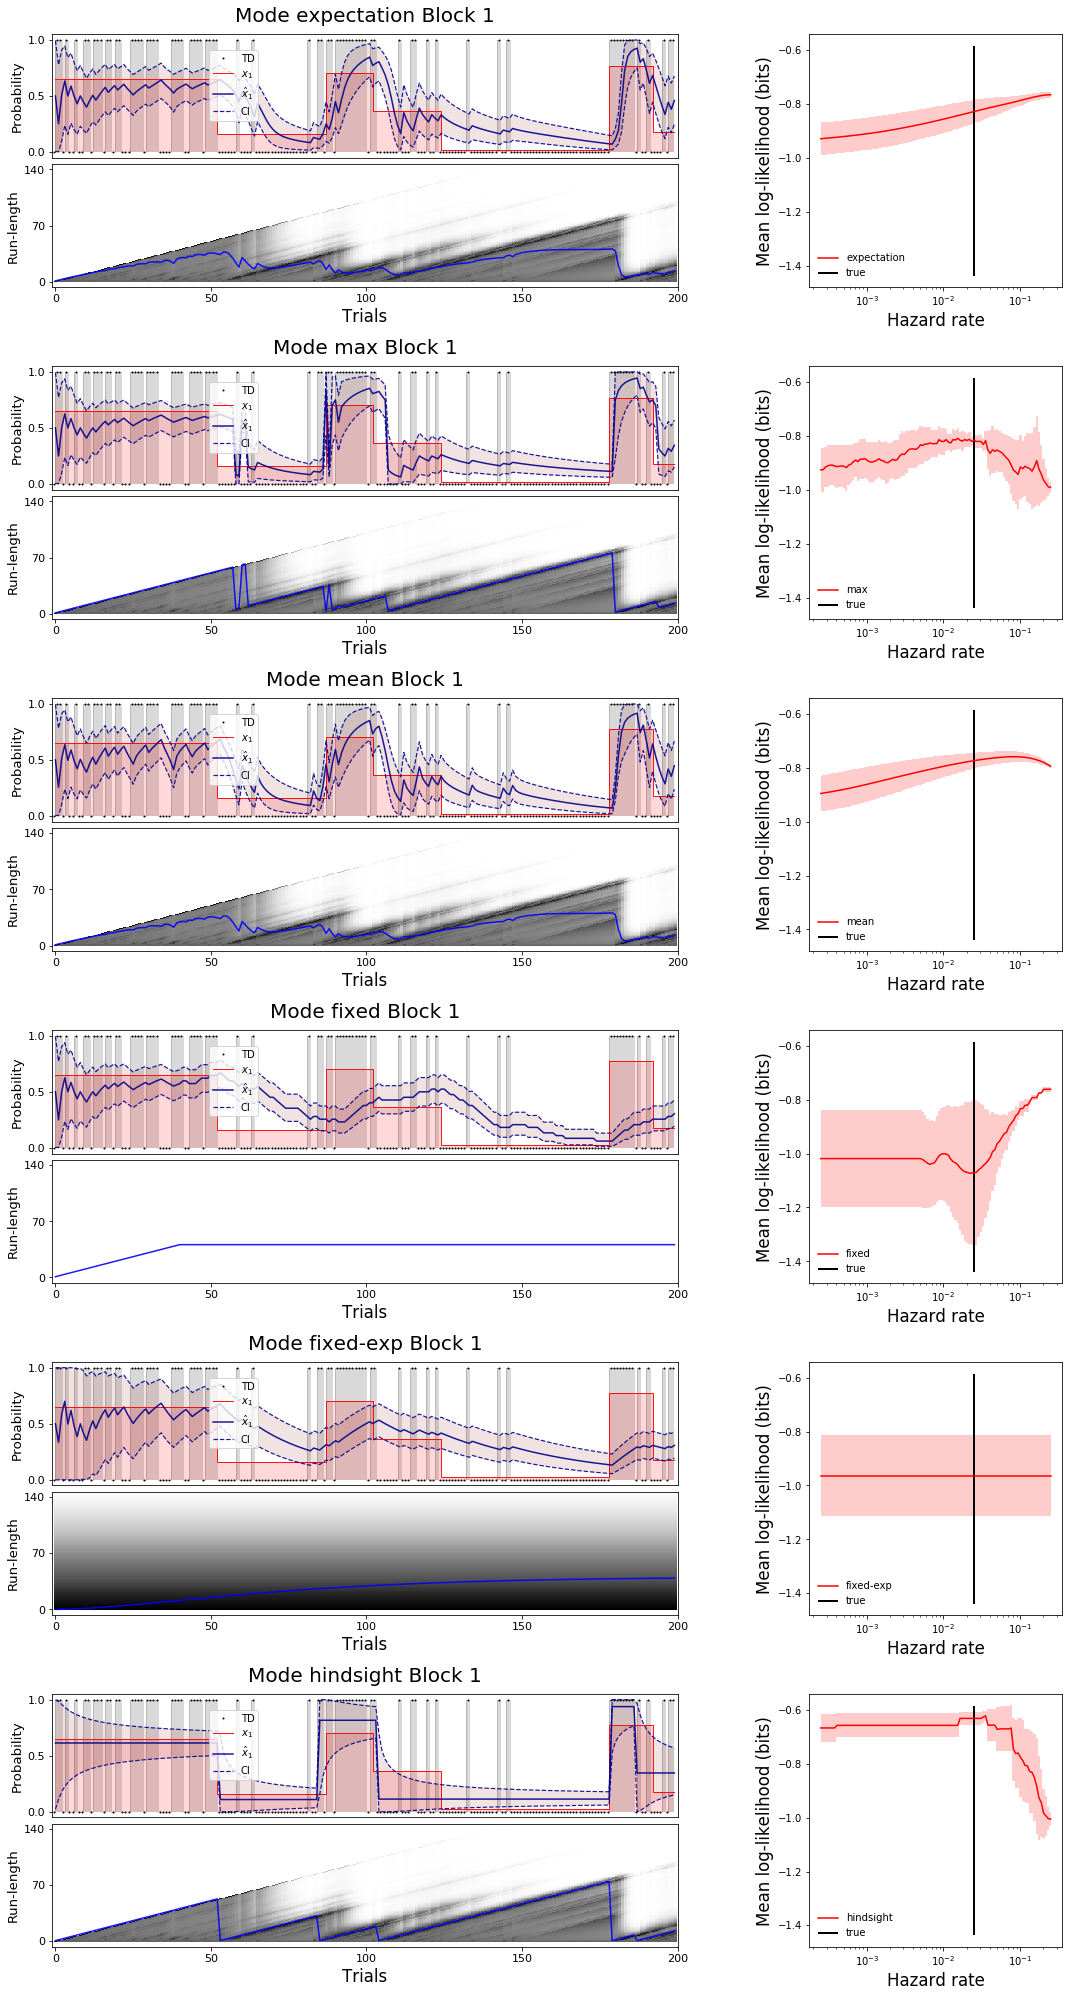

AttributeError: 'tuple' object has no attribute 'savefig'

In [20]:
fig = e.plot_bcp(show_trial=False, N_scan=N_scan)
for ext in exts: fig.savefig('figures/BCP/BCP_scan' + ext, dpi=dpi)

In [ ]:
fig = e.plot_bcp(show_trial=False, N_scan=N_scan, pause=True)
#for ext in exts: fig.savefig('figures/BCP/BCP_scan' + ext, dpi=dpi)

TODO: plot pout chaque r la distriubtion Beta correspondant à $P(p |r) = B(p; p(r)*r, (1-p(r))*r)$

In [ ]:
%ls {msfigpath}